# Retraction Examples
Examples of different ways to implement retraction of fronts:
- retract randomly a single terminal front: [Single_front_retraction](#Single_front_retraction)
- retract somata: [Soma_retraction](#Soma_retraction)
- retract randomly an entire branch: main branches are retracted randomly: [Branch_retraction](#Branch_retraction)

## Single_front_retraction
Single fronts are retracted randomly, these fronts have to be at terminal tips

<IPython.core.display.Javascript object>


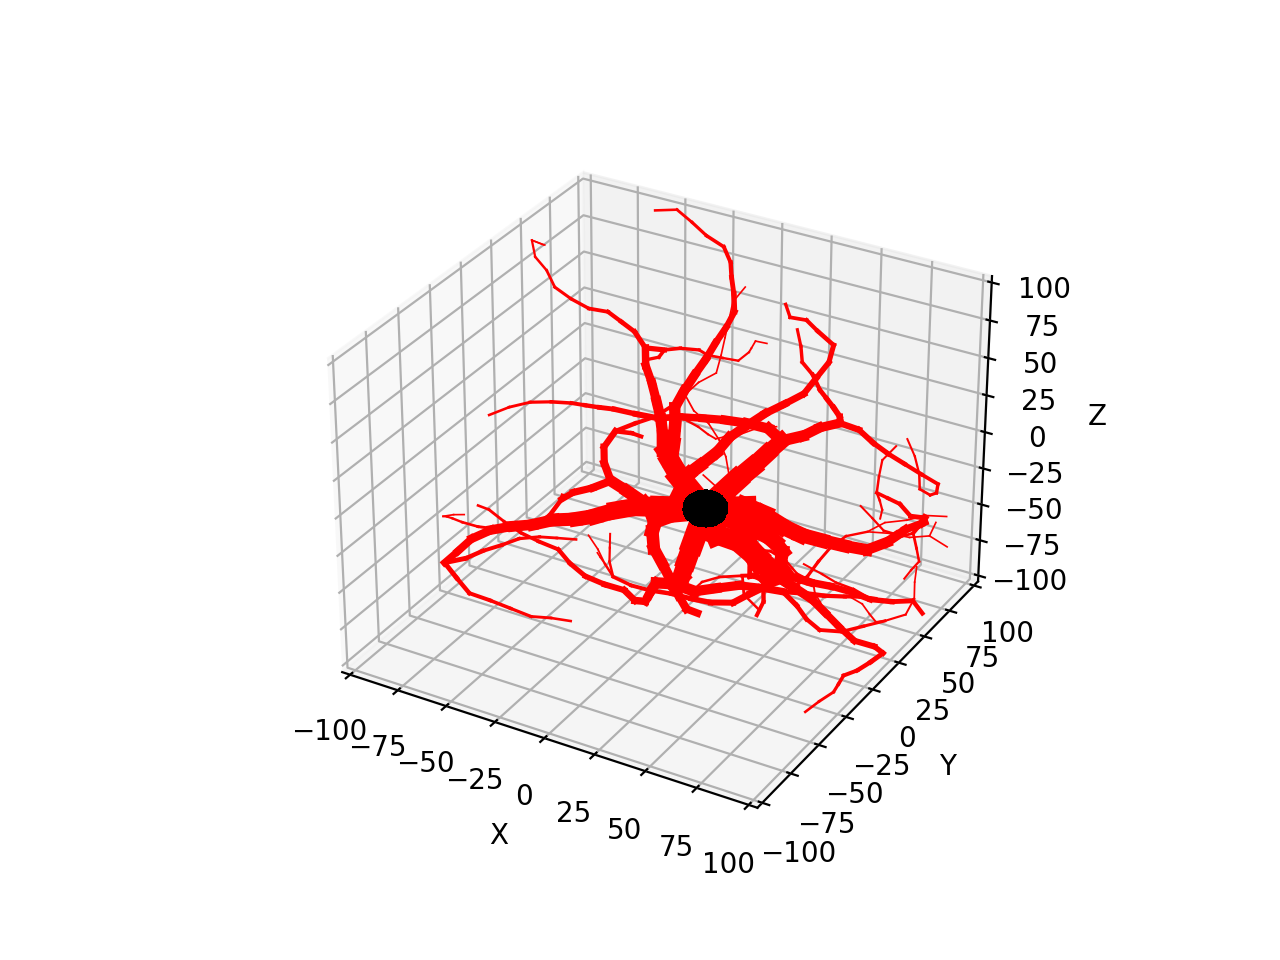

cycle 11 RETRACTING front Growing front 8032 (1): [-33.36, -32.36, -5.42] [-27.55, -35.87, 1.93] radius: 0.73 path_length: 110.00 swc: 3 order: 4, parent: 16030 with 0 children, soma 1, made at 10 (7 -40083)
cycleRETRACTING front 12  Growing front 12040 (1): [-19.90, 12.70, 9.91] [-10.65, 8.98, 10.74] radius: 0.66 path_length: 120.00 swc: 3 order: 4, parent: 12036 with 0 children, soma 1, made at 11 (7 -60106)
cycle 14 RETRACTING front Growing front 16051 (1): [-31.90, 39.30, 40.61] [-39.33, 42.43, 34.69] radius: 0.53 path_length: 140.00 swc: 3 order: 4, parent: 8041 with 0 children, soma 1, made at 13 (7 -80135)


In [1]:
%matplotlib notebook 

from neurodevsim.simulator import *
import numpy as np
import time

# The postsynaptic neuron
class RetractionNeuronFront(SynFront):
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            points = self.unit_branching_sample(16)  # generate vectors
            num_dend = 0 # count number of dendrites
            for p in points: # make 10 dendrites
                new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                # check for possible collisions
                try:
                    new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3) # make a new front
                    num_dend += 1
                    if num_dend == 10: # enough dendrites made
                        # make soma inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                    continue # pick another new_pos, no attempt to correct the error
            print ("Warning: less than 10 dendrites made for",self.get_neuron_name(constellation),num_dend)
            # make soma inactive: stops growing -> will not call this method again
            self.disable(constellation)
        else:
            if self.path_length >= 200:
                self.disable(constellation) # terminus: stop growing
                return
            if (self.order > 3) and (np.random.random() < 0.025):
                print ("cycle",constellation.cycle,"RETRACTING front",self)
                self.retract(constellation)
                return
            bif_prob = 0.40 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.04
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 10:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        # make front inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    self.disable(constellation) # stop trying
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            # make front inactive: stops growing -> will not call this method again
                            self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/retraction_1.db"
    sim_volume = [[-100., -100., -100.], [100.0,100.0,100.0]]
    neuron_types = [RetractionNeuronFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True)

    # make soma and set neuron name
    admin.add_neurons(RetractionNeuronFront,"retract1_neuron",1,[[-30,-30,-30],[30,30,30]],10.)

    # run the simulation
    admin.simulation_loop(40)

    # clean up
    admin.destruction()

## Soma_retraction
Random retraction of somata, no growth of dendrites.

<IPython.core.display.Javascript object>


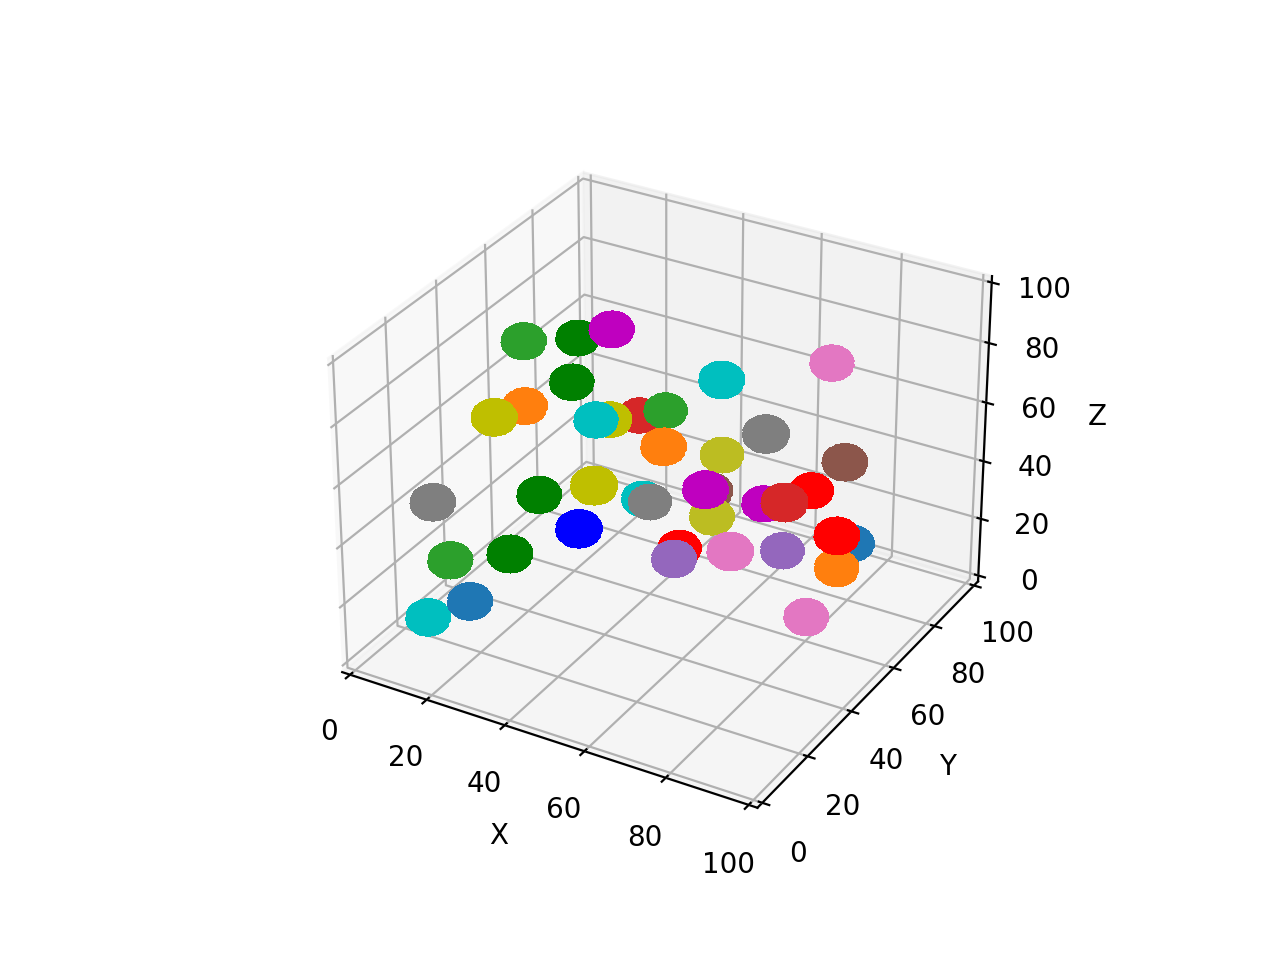

cyclecyclecycle   222   RETRACTING somaRETRACTING somaRETRACTING soma   42216


cyclecycle 3  3RETRACTING soma  RETRACTING soma41 
30
cycle 5 RETRACTING soma 24
cycle 6 RETRACTING soma 38
cycle 7 RETRACTING soma 47
cyclecycle  1010  RETRACTING somaRETRACTING soma  3249



In [3]:
from neurodevsim.simulator import *
import numpy as np

class SomaRetract(Front):
    
    # No additional fronts made
    def manage_front(self,constellation):
        if np.random.random() < 0.02: # retract
            print ("cycle",constellation.cycle,"RETRACTING soma",self._fid)
            self.retract(constellation)
            return

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/50retract.db"
    sim_volume = [[0., 0., 0.], [100.0,100.0,100.0]]
    neuron_types = [SomaRetract]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,seed=1,plot=True,soma_black=False)

    # make 50 somata and set neuron name
    admin.add_neurons(SomaRetract,"neuron",50,[[10,10,10],[90,90,90]],5.)

    # run the simulation
    admin.simulation_loop(10)

    # clean up
    admin.destruction()

## Branch_retraction
Retract an entire branch: this is triggered randomly in the root segment of branches.

<IPython.core.display.Javascript object>


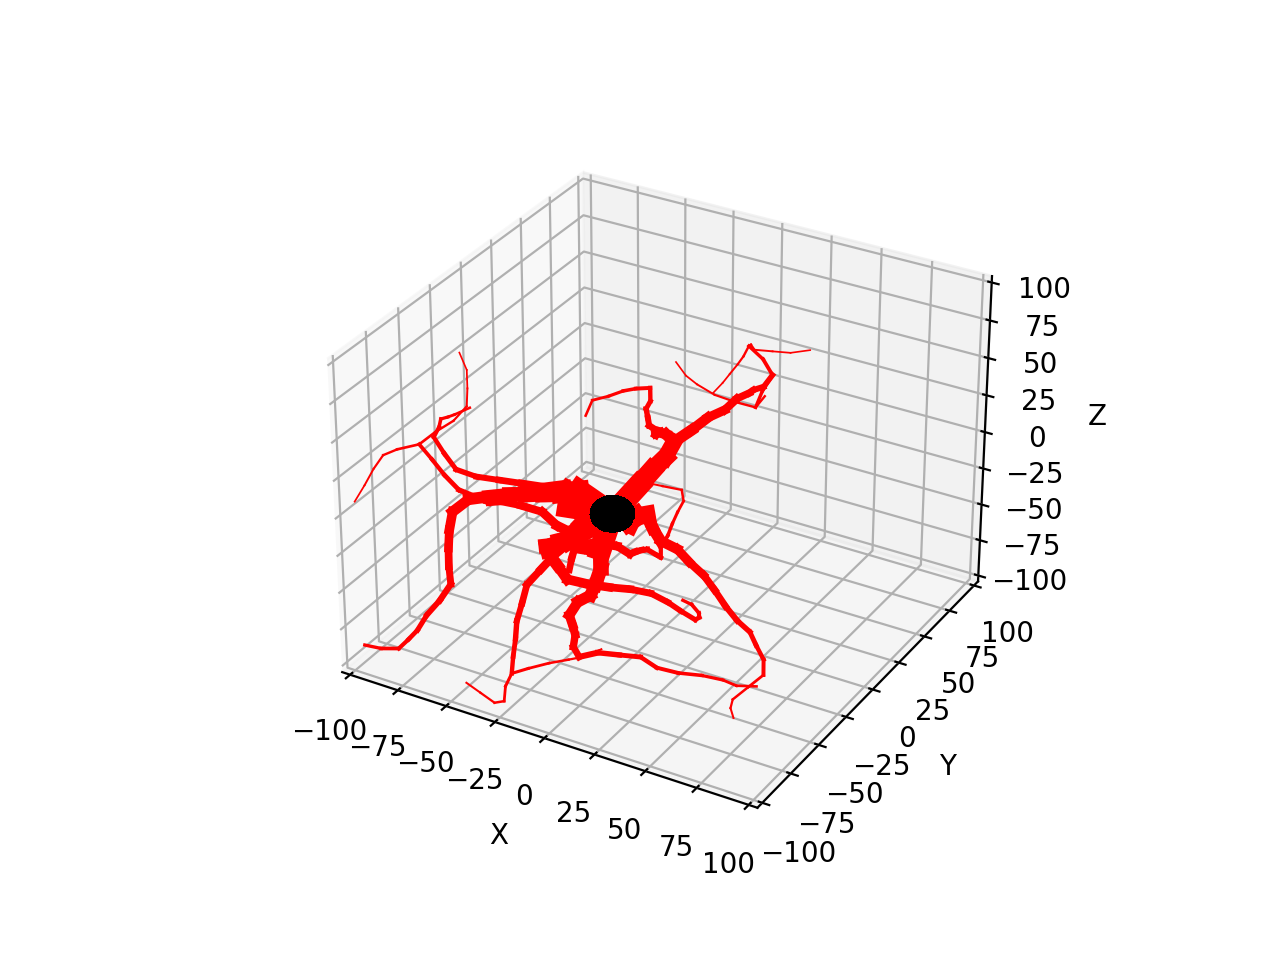

cycle 11 RETRACTING branch # 6
cycle 15 RETRACTING branch # 7
cycle 26 RETRACTING branch # 0


In [6]:
from neurodevsim.simulator import *
import numpy as np
import time

# The postsynaptic neuron
class RetractionBranchFront(SynFront):
    
    def manage_front(self,constellation):
        if self.swc_type == 1: # this is the soma
            if self.is_growing():
                points = self.unit_branching_sample(16)  # generate vectors
                num_dend = 0 # count number of dendrites
                for p in points: # make 10 dendrites
                    new_pos = self.orig + p * (10. + self.radius) # compute position of dendrite end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=4.,swc_type=3) # make a new front
                        num_dend += 1
                        if num_dend == 10: # enough dendrites made
                            # make soma stops growing but stays active
                            self.clear_growing()
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                print ("Warning: less than 10 dendrites made for",self.get_neuron_name(constellation),num_dend)
                # make soma stop growing -> will not call this method again
                self.clear_growing()
            elif constellation.cycle > 5: # maybe retract a main branch
                if np.random.random() < 0.06: # retract a random branch
                    children = self.get_children(constellation)
                    index = np.random.randint(len(children))
                    print ("cycle",constellation.cycle,"RETRACTING branch #",index)
                    self.retract_branch(constellation,children[index])
            return
        else: # only growing tips
            if self.path_length >= 200:
                self.disable(constellation) # terminus: stop growing
                return
            bif_prob = 0.40 / (self.order*3)
            if self.order > 4 :
                bif_prob = 0.04
            if np.random.random() > bif_prob: # continue a front
                # taper radius
                rad = self.taper(0.9)
                count = 0 # counts number of add_child trials
                while count < 10:
                    # random component along current heading
                    extension = self.unit_heading_sample(width=20)
                    new_pos = self.end + extension * 10. # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        # make front inactive: stops growing -> will not call this method again
                        self.disable(constellation)
                        return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        count += 1
                        continue # pick another new_pos, no attempt to correct the error
                if (constellation.cycle - self.birth) > 2: # this was second failed attempt:
                    self.disable(constellation) # stop trying
            else: # branch a front: generate two child fronts, or terminate
                points = self.unit_branching_sample(5) # generate more points than needed
                rad = self.taper(0.7) # strongly taper radius
                num_dend = 0 # count number of dendrite branches
                for p in points: # make 2 branches
                    new_pos = self.end + p * 10.  # compute position of child end
                    # check for possible collisions
                    try:
                        new_front = self.add_child(constellation,new_pos,radius=rad) # make a new front
                        num_dend += 1
                        if num_dend == 2: # enough dendrites made
                            # make front inactive: stops growing -> will not call this method again
                            self.disable(constellation)
                            return # completed this call
                    except (CollisionError, GridCompetitionError, InsideParentError, VolumeError):
                        continue # pick another new_pos, no attempt to correct the error
                if self.num_children > 0: # single child made -> make front inactive
                    self.disable(constellation)

if __name__ == '__main__':

    # initialize Admin_agent
    fname = "output/retraction_b.db"
    sim_volume = [[-100., -100., -100.], [100.0,100.0,100.0]]
    neuron_types = [RetractionBranchFront]
    admin = Admin_agent(4,fname,sim_volume,neuron_types,verbose=0,plot=True)

    # make soma and set neuron name
    admin.add_neurons(RetractionBranchFront,"retractb_neuron",1,[[-30,-30,-30],[30,30,30]],10.)

    # run the simulation
    admin.simulation_loop(40)

    # clean up
    admin.destruction()